## Social media sentiment analysis

In [1]:
!pip install contractions missingno wordcloud

     ------------------------------------ 289.9/289.9 kB 146.7 kB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import warnings
warnings.filterwarnings(action='ignore')

import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize, sent_tokenize 
from nltk.stem import LancasterStemmer, WordNetLemmatizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
import re
import string
import unicodedata
import contractions
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import wordcloud
from wordcloud import STOPWORDS, WordCloud
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (
     recall_score,
    accuracy_score,
    confusion_matrix,
    classification_report,
    f1_score,
    precision_score,
    precision_recall_fscore_support
)

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vaidhehi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Vaidhehi\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Vaidhehi\AppData\Roaming\nltk_data...


In [3]:
df = pd.read_csv("C:/Users/Vaidhehi/Tweets.csv")
df.head()

tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   
2  570301083672813571           neutral                        0.6837   
3  570301031407624196          negative                        1.0000   
4  570300817074462722          negative                        1.0000   

  negativereason  negativereason_confidence         airline  \
0            NaN                        NaN  Virgin America   
1            NaN                     0.0000  Virgin America   
2            NaN                        NaN  Virgin America   
3     Bad Flight                     0.7033  Virgin America   
4     Can't Tell                     1.0000  Virgin America   

  airline_sentiment_gold        name negativereason_gold  retweet_count  \
0                    NaN     cairdin                 NaN              0   
1                    NaN    jnardino                 NaN              0   
2                    NaN  yvonnalynn                 NaN              0   
3                    NaN    jnardino                 NaN              0   
4                    NaN    jnardino                 NaN              0   

                                                text tweet_coord  \
0                @VirginAmerica What @dhepburn said.         NaN   
1  @VirginAmerica plus you've added commercials t...         NaN   
2  @VirginAmerica I didn't today... Must mean I n...         NaN   
3  @VirginAmerica it's really aggressive to blast...         NaN   
4  @VirginAmerica and it's a really big bad thing...         NaN   

               tweet_created tweet_location               user_timezone  
0  2015-02-24 11:35:52 -0800            NaN  Eastern Time (US & Canada)  
1  2015-02-24 11:15:59 -0800            NaN  Pacific Time (US & Canada)  
2  2015-02-24 11:15:48 -0800      Lets Play  Central Time (US & Canada)  
3  2015-02-24 11:15:36 -0800            NaN  Pacific Time (US & Canada)  
4  2015-02-24 11:14:45 -0800            NaN  Pacific Time (US & Canada)

In [4]:
texts = [[word.lower() for word in text.split()] for text in df]

In [5]:
df.head()

tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   
2  570301083672813571           neutral                        0.6837   
3  570301031407624196          negative                        1.0000   
4  570300817074462722          negative                        1.0000   

  negativereason  negativereason_confidence         airline  \
0            NaN                        NaN  Virgin America   
1            NaN                     0.0000  Virgin America   
2            NaN                        NaN  Virgin America   
3     Bad Flight                     0.7033  Virgin America   
4     Can't Tell                     1.0000  Virgin America   

  airline_sentiment_gold        name negativereason_gold  retweet_count  \
0                    NaN     cairdin                 NaN              0   
1                    NaN    jnardino                 NaN              0   
2                    NaN  yvonnalynn                 NaN              0   
3                    NaN    jnardino                 NaN              0   
4                    NaN    jnardino                 NaN              0   

                                                text tweet_coord  \
0                @VirginAmerica What @dhepburn said.         NaN   
1  @VirginAmerica plus you've added commercials t...         NaN   
2  @VirginAmerica I didn't today... Must mean I n...         NaN   
3  @VirginAmerica it's really aggressive to blast...         NaN   
4  @VirginAmerica and it's a really big bad thing...         NaN   

               tweet_created tweet_location               user_timezone  
0  2015-02-24 11:35:52 -0800            NaN  Eastern Time (US & Canada)  
1  2015-02-24 11:15:59 -0800            NaN  Pacific Time (US & Canada)  
2  2015-02-24 11:15:48 -0800      Lets Play  Central Time (US & Canada)  
3  2015-02-24 11:15:36 -0800            NaN  Pacific Time (US & Canada)  
4  2015-02-24 11:14:45 -0800            NaN  Pacific Time (US & Canada)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [7]:
df.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

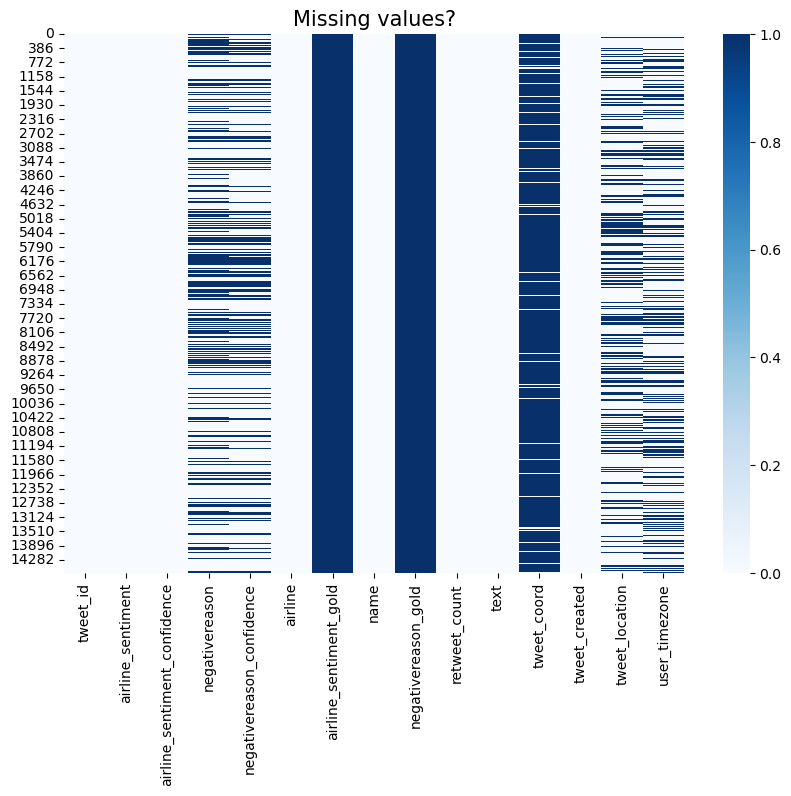

In [8]:
plt.figure(figsize=(10,7))
sns.heatmap(df.isnull(), cmap = "Blues")                       
plt.title("Missing values?", fontsize = 15)
plt.show()

In [9]:
print("Percentage null or na values in df")
((df.isnull() | df.isna()).sum() * 100 / df.index.size).round(2)

Percentage null or na values in df


tweet_id                         0.00
airline_sentiment                0.00
airline_sentiment_confidence     0.00
negativereason                  37.31
negativereason_confidence       28.13
airline                          0.00
airline_sentiment_gold          99.73
name                             0.00
negativereason_gold             99.78
retweet_count                    0.00
text                             0.00
tweet_coord                     93.04
tweet_created                    0.00
tweet_location                  32.33
user_timezone                   32.92
dtype: float64

In [10]:
df.drop(["tweet_coord", "airline_sentiment_gold", "negativereason_gold"], axis=1, inplace=True)

In [11]:
df.head()

tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   
2  570301083672813571           neutral                        0.6837   
3  570301031407624196          negative                        1.0000   
4  570300817074462722          negative                        1.0000   

  negativereason  negativereason_confidence         airline        name  \
0            NaN                        NaN  Virgin America     cairdin   
1            NaN                     0.0000  Virgin America    jnardino   
2            NaN                        NaN  Virgin America  yvonnalynn   
3     Bad Flight                     0.7033  Virgin America    jnardino   
4     Can't Tell                     1.0000  Virgin America    jnardino   

   retweet_count                                               text  \
0              0                @VirginAmerica What @dhepburn said.   
1              0  @VirginAmerica plus you've added commercials t...   
2              0  @VirginAmerica I didn't today... Must mean I n...   
3              0  @VirginAmerica it's really aggressive to blast...   
4              0  @VirginAmerica and it's a really big bad thing...   

               tweet_created tweet_location               user_timezone  
0  2015-02-24 11:35:52 -0800            NaN  Eastern Time (US & Canada)  
1  2015-02-24 11:15:59 -0800            NaN  Pacific Time (US & Canada)  
2  2015-02-24 11:15:48 -0800      Lets Play  Central Time (US & Canada)  
3  2015-02-24 11:15:36 -0800            NaN  Pacific Time (US & Canada)  
4  2015-02-24 11:14:45 -0800            NaN  Pacific Time (US & Canada)

In [12]:
freq = df.groupby("negativereason").size()

In [13]:
df.duplicated().sum()

39

In [14]:

df.drop_duplicates(inplace = True)

In [15]:
df.duplicated().sum()

0

In [16]:
df.describe().T

count          mean           std  \
tweet_id                      14601.0  5.692156e+17  7.782706e+14   
airline_sentiment_confidence  14601.0  8.999022e-01  1.629654e-01   
negativereason_confidence     10501.0  6.375749e-01  3.303735e-01   
retweet_count                 14601.0  8.280255e-02  7.467231e-01   

                                       min           25%           50%  \
tweet_id                      5.675883e+17  5.685581e+17  5.694720e+17   
airline_sentiment_confidence  3.350000e-01  6.923000e-01  1.000000e+00   
negativereason_confidence     0.000000e+00  3.605000e-01  6.705000e-01   
retweet_count                 0.000000e+00  0.000000e+00  0.000000e+00   

                                       75%           max  
tweet_id                      5.698884e+17  5.703106e+17  
airline_sentiment_confidence  1.000000e+00  1.000000e+00  
negativereason_confidence     1.000000e+00  1.000000e+00  
retweet_count                 0.000000e+00  4.400000e+01

In [17]:
df.nunique()

tweet_id                        14485
airline_sentiment                   3
airline_sentiment_confidence     1023
negativereason                     10
negativereason_confidence        1410
airline                             6
name                             7701
retweet_count                      18
text                            14427
tweet_created                   14247
tweet_location                   3081
user_timezone                      85
dtype: int64

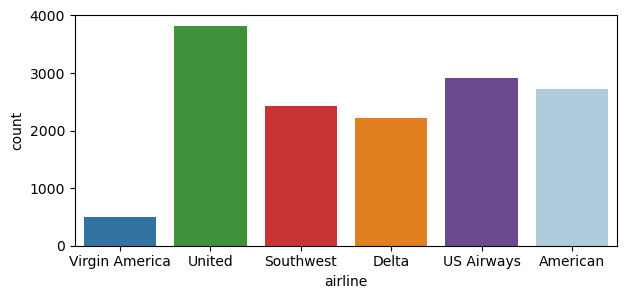

In [18]:
plt.figure(figsize=(7,3))
sns.countplot(data=df,x='airline', palette=['#1f78b4', '#33a02c', '#e31a1c', '#ff7f00', '#6a3d9a', '#a6cee3'])
plt.show()

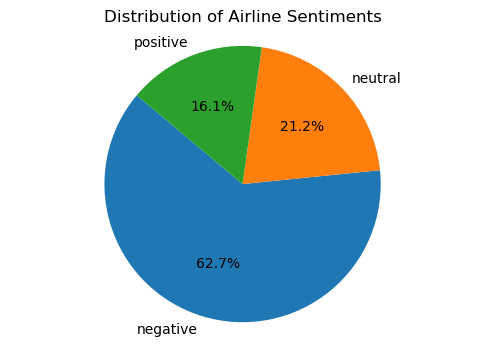

In [19]:
sentiment_counts = df['airline_sentiment'].value_counts()
plt.figure(figsize=(6, 4))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Airline Sentiments')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

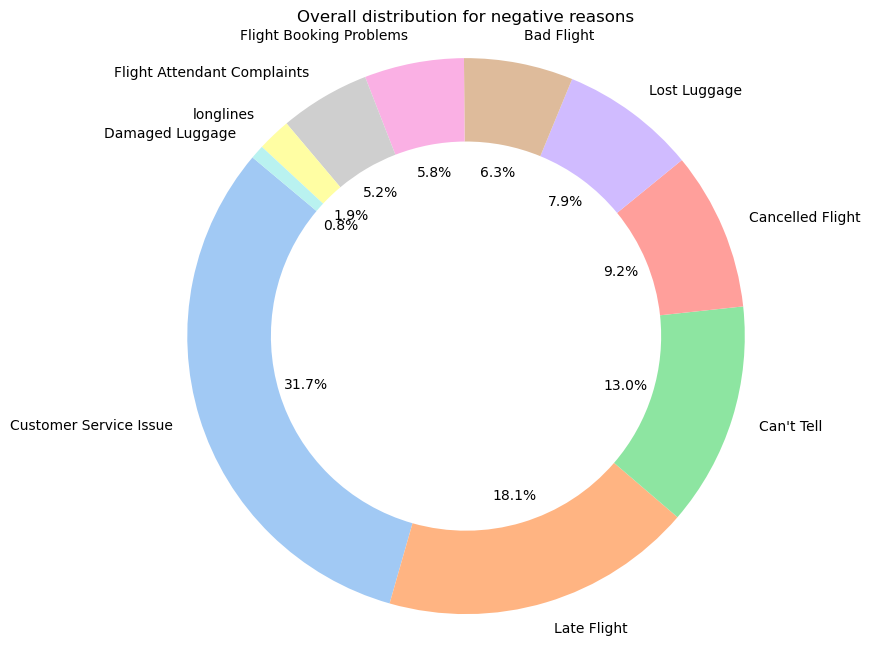

In [20]:
value_counts = df['negativereason'].value_counts()

plt.figure(figsize=(8, 8))
labels = value_counts.index
values = value_counts.values
colors = sns.color_palette('pastel')[0:len(labels)]  # Use pastel colors for the chart
plt.pie(values, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, wedgeprops=dict(width=0.3))
plt.title('Overall distribution for negative reasons')
plt.axis('equal') 
plt.show()

In [21]:
df = df[['airline_sentiment', 'text']].copy()

In [22]:
df

airline_sentiment                                               text
0               neutral                @VirginAmerica What @dhepburn said.
1              positive  @VirginAmerica plus you've added commercials t...
2               neutral  @VirginAmerica I didn't today... Must mean I n...
3              negative  @VirginAmerica it's really aggressive to blast...
4              negative  @VirginAmerica and it's a really big bad thing...
...                 ...                                                ...
14635          positive  @AmericanAir thank you we got on a different f...
14636          negative  @AmericanAir leaving over 20 minutes Late Flig...
14637           neutral  @AmericanAir Please bring American Airlines to...
14638          negative  @AmericanAir you have my money, you change my ...
14639           neutral  @AmericanAir we have 8 ppl so we need 2 know h...

[14601 rows x 2 columns]

In [23]:
X = df["text"]
y = df["airline_sentiment"]

In [24]:
X

0                      @VirginAmerica What @dhepburn said.
1        @VirginAmerica plus you've added commercials t...
2        @VirginAmerica I didn't today... Must mean I n...
3        @VirginAmerica it's really aggressive to blast...
4        @VirginAmerica and it's a really big bad thing...
                               ...                        
14635    @AmericanAir thank you we got on a different f...
14636    @AmericanAir leaving over 20 minutes Late Flig...
14637    @AmericanAir Please bring American Airlines to...
14638    @AmericanAir you have my money, you change my ...
14639    @AmericanAir we have 8 ppl so we need 2 know h...
Name: text, Length: 14601, dtype: object

In [25]:
y

0         neutral
1        positive
2         neutral
3        negative
4        negative
           ...   
14635    positive
14636    negative
14637     neutral
14638    negative
14639     neutral
Name: airline_sentiment, Length: 14601, dtype: object

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [27]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(11680,) (2921,) (11680,) (2921,)


In [28]:
tfidf = TfidfVectorizer(stop_words="english")

In [29]:
tfidf.fit(X_train)

TfidfVectorizer(stop_words='english')

In [30]:
print(tfidf.get_feature_names_out())

['00' '000' '000114' ... 'zv2pt6trk9' 'zv6cfpohl5' 'zvfmxnuelj']


In [31]:
print(tfidf.vocabulary_)

{'americanair': 1935, 'boarded': 2689, 'flight': 5211, '2334': 504, '30am': 671, '11': 99, '40': 825, 'sitting': 10557, 'runway': 10091, 'lots': 7411, 'fun': 5498, 'united': 12078, 'sent': 10352, 'hayden': 5973, 'steamboat': 10923, 'hdn': 5980, 'denver': 4088, 'hoping': 6182, '2396': 512, 'cancelled': 3009, 'flightled': 5240, 'tonight': 11609, 'usairways': 12220, 'ticket': 11506, 'counter': 3740, 'people': 8866, 'helping': 6034, 'just': 6879, 'want': 12492, 'charge': 3194, 'money': 7927, 'horrible': 6189, 'day': 3976, '132': 178, 'characters': 3193, 'does': 4371, 'cover': 3764, 'reasons': 9579, 'afraid': 1766, '30': 655, '1750': 304, 'trying': 11772, 'tel': 11335, 'aviv': 2289, 'right': 9947, 'cruel': 3834, '350pm': 726, 'hours': 6220, 'hold': 6124, 'customer': 3884, 'service': 10373, 'answering': 2020, 'ridiculous': 9942, 'seat': 10288, '10d': 86, 'vegas': 12317, 'chicago': 3252, 'left': 7168, 'folder': 5332, 'looks': 7388, 'important': 6392, 'pocket': 9055, 'xna': 12869, 'tsa': 11777

In [32]:
count_vect = CountVectorizer(stop_words="english")
neg_matrix = count_vect.fit_transform(df[df["airline_sentiment"]=="negative"]["text"])
freqs = zip(count_vect.get_feature_names_out(), neg_matrix.sum(axis=0).tolist()[0])
# Sort from largest to smallest
print(sorted(freqs, key=lambda x: -x[1])[:100])

[('flight', 2937), ('united', 2899), ('usairways', 2375), ('americanair', 2089), ('southwestair', 1214), ('jetblue', 1051), ('cancelled', 921), ('service', 746), ('hours', 646), ('just', 622), ('help', 618), ('hold', 611), ('customer', 609), ('time', 596), ('plane', 530), ('delayed', 505), ('amp', 503), ('hour', 452), ('flightled', 445), ('http', 436), ('flights', 419), ('bag', 415), ('gate', 410), ('ve', 398), ('don', 388), ('late', 377), ('need', 373), ('phone', 367), ('waiting', 341), ('thanks', 315), ('got', 298), ('airline', 294), ('like', 291), ('trying', 288), ('delay', 272), ('wait', 272), ('today', 269), ('minutes', 266), ('day', 251), ('going', 249), ('bags', 245), ('luggage', 245), ('told', 245), ('airport', 244), ('people', 242), ('worst', 241), ('fly', 237), ('really', 236), ('did', 227), ('guys', 224), ('weather', 224), ('lost', 221), ('agent', 218), ('hrs', 217), ('way', 212), ('make', 211), ('change', 210), ('seat', 208), ('flighted', 205), ('want', 205), ('check', 204)

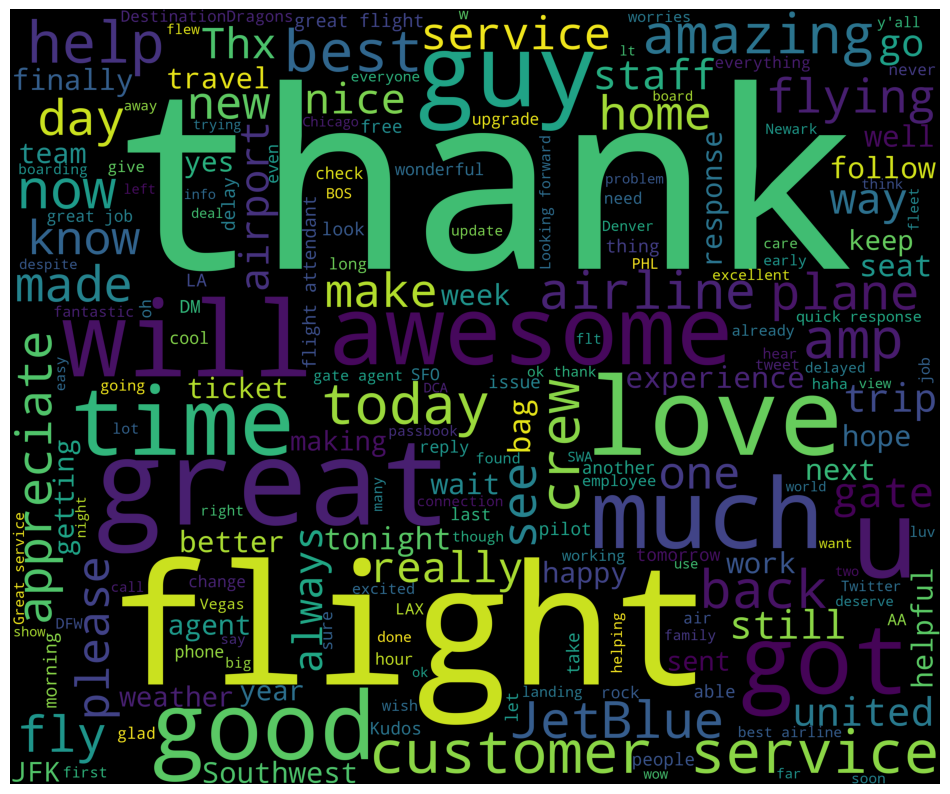

In [33]:
new_df = df[df["airline_sentiment"] == "positive"]
words = " ".join(new_df["text"])
cleaned_word = " ".join([word for word in words.split() if "http" not in word and not word.startswith("@") and word != "RT"])
wordcloud = WordCloud(stopwords = STOPWORDS,
                     background_color = "black", width = 3000, height = 2500).generate(cleaned_word)
plt.figure(figsize = (12, 12))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

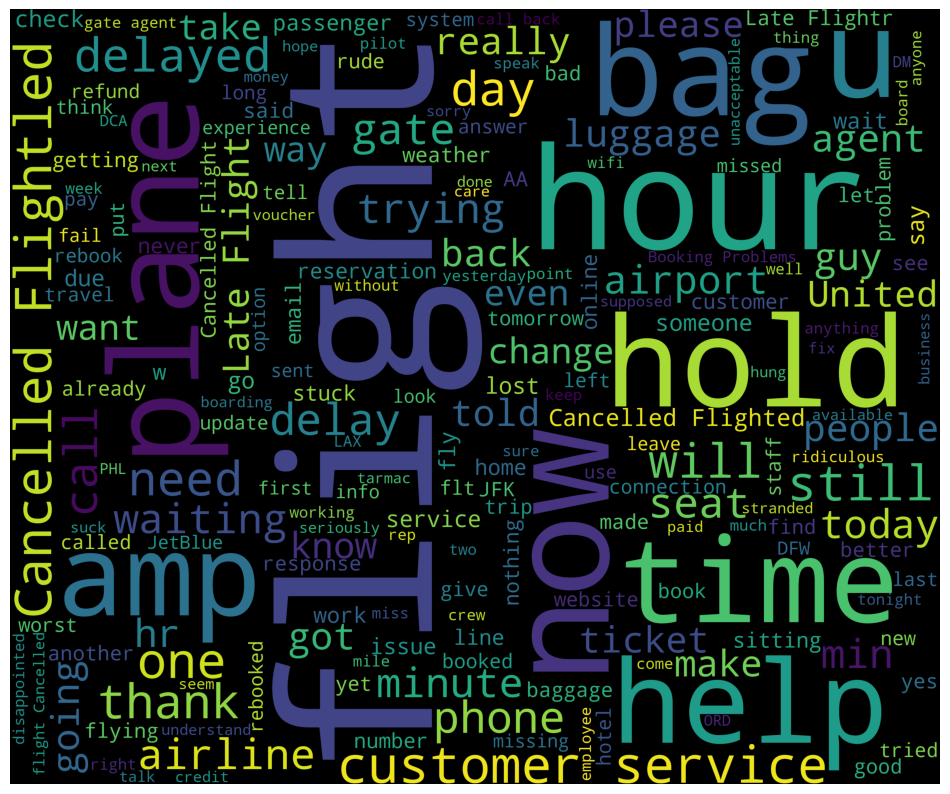

In [4]:
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
df = pd.read_csv("C:/Users/Vaidhehi/Tweets.csv")

new_df = df[df["airline_sentiment"] == "negative"]
words = " ".join(new_df["text"])
cleaned_word = " ".join([word for word in words.split() if "http" not in word and not word.startswith("@") and word != "RT"])
wordcloud = WordCloud(stopwords = STOPWORDS,
                     background_color = "black", width = 3000, height = 2500).generate(cleaned_word)
plt.figure(figsize = (12, 12))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [3]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
df = pd.read_csv("C:/Users/Vaidhehi/Tweets.csv")
le = LabelEncoder()

le.fit(df["airline_sentiment"])
df["airline_sentiment_encoded"] = le.transform(df["airline_sentiment"])
df.head()

tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   
2  570301083672813571           neutral                        0.6837   
3  570301031407624196          negative                        1.0000   
4  570300817074462722          negative                        1.0000   

  negativereason  negativereason_confidence         airline  \
0            NaN                        NaN  Virgin America   
1            NaN                     0.0000  Virgin America   
2            NaN                        NaN  Virgin America   
3     Bad Flight                     0.7033  Virgin America   
4     Can't Tell                     1.0000  Virgin America   

  airline_sentiment_gold        name negativereason_gold  retweet_count  \
0                    NaN     cairdin                 NaN              0   
1                    NaN    jnardino                 NaN              0   
2                    NaN  yvonnalynn                 NaN              0   
3                    NaN    jnardino                 NaN              0   
4                    NaN    jnardino                 NaN              0   

                                                text tweet_coord  \
0                @VirginAmerica What @dhepburn said.         NaN   
1  @VirginAmerica plus you've added commercials t...         NaN   
2  @VirginAmerica I didn't today... Must mean I n...         NaN   
3  @VirginAmerica it's really aggressive to blast...         NaN   
4  @VirginAmerica and it's a really big bad thing...         NaN   

               tweet_created tweet_location               user_timezone  \
0  2015-02-24 11:35:52 -0800            NaN  Eastern Time (US & Canada)   
1  2015-02-24 11:15:59 -0800            NaN  Pacific Time (US & Canada)   
2  2015-02-24 11:15:48 -0800      Lets Play  Central Time (US & Canada)   
3  2015-02-24 11:15:36 -0800            NaN  Pacific Time (US & Canada)   
4  2015-02-24 11:14:45 -0800            NaN  Pacific Time (US & Canada)   

   airline_sentiment_encoded  
0                          1  
1                          2  
2                          1  
3                          0  
4                          0

In [9]:
import nltk
from nltk.corpus import stopwords
def tweet_to_words(tweet):
    nltk.download("stopwords")

df["clean_tweet"] = df["text"].apply(lambda x: tweet_to_words(x))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vaidhehi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vaidhehi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vaidhehi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vaidhehi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vaidhehi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vaidhehi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloadin

[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vaidhehi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vaidhehi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vaidhehi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vaidhehi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vaidhehi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vaidhehi\AppData\Roaming\nltk_data...
[nltk_data]   Package 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vaidhehi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vaidhehi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vaidhehi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vaidhehi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vaidhehi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vaidhehi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloadin

[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vaidhehi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vaidhehi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vaidhehi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vaidhehi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vaidhehi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vaidhehi\AppData\Roaming\nltk_data...
[nltk_data]   Package 

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [11]:
X = df["clean_tweet"]
y = df["airline_sentiment"]

In [12]:
print(X.shape, y.shape)

(14640,) (14640,)


In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)